In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.constants import N_A
import pints
from scipy.integrate import solve_ivp
import pints.plot
sns.set_context('talk')

In [138]:
Target_cell_number = 2e4
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
tumour_cell_radius = 7.25e-6
receptor_quant = {'500G_F': 11902, 'MSX_B':1713701, '500G_B':123366, '500G_L':2831,
                  '250G_A':124222, '250G_C': 91578, 'MSX_A': 1843343, 'MSX_C':1584638,
                  'MSX_D': 2158, 'MSX_E': 2478, 'MSX_F': 17469, '500G_A': 120454,
                  '500G_C': 107181, '500G_D': 9824, '500G_E': 6719, '500G_H': 6341,
                  '500G_I': 8195, '500G_J': 7960, '500G_K': 2174, 'MSX_I': 52886}
t_end = 60*60*1
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]


In [139]:
df = pd.read_excel(r'/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Data/RE_ Mono vs Bivalent cell binding data - high affinity Ab/ELN339638_Tabular.xlsx')
df = df.dropna(subset=['CELL_ID']).reset_index(drop=True)
cell_ids = list(set(df['CELL_ID'].values))
antibody_ids1 = list(set(df['ANTIBODY_ID'].values))
antibody_ids = [x for x in antibody_ids1 if str(x) != 'nan']
antibody_ids.remove('RSV')

def data_extractor(df, cell_id, antibody_id):

    detect_id = 'RL-2'
    df1 = df.query('CELL_ID==@cell_id & ANTIBODY_ID==@antibody_id & DETECTOR==@detect_id')
    mono_df = df1.query('ANTIBODY_FORMAT=="MONOVALENT"')
    biv_df = df1.query('ANTIBODY_FORMAT=="BIVALENT"')

    concs = list(np.flip(mono_df['ANTIBODY_CONCENTRATION_MOLAR'].values))
    response_mono = list(np.flip(mono_df['RESPONSE'].values))
    response_biv = list(np.flip(biv_df['RESPONSE'].values))
    
    return response_mono, response_biv, concs

In [140]:
monos = []
bivs = []
concs = []
data = []
maxs =[]
rtots = []
for cell_id in cell_ids:
    for antibody_id in antibody_ids:
        mono, biv, conc = data_extractor(df, cell_id, antibody_id)
        #remove last data point
        mono = np.array(mono[:-1])
        biv = np.array(biv[:-1])
        conc = np.array(conc[:-1])

        rtot = receptor_quant[cell_id]
        rtot = rtot - 2000
        rtots.append(rtot)
        
        mono, biv = mono/rtot, biv/rtot
        monos.append(mono)
        bivs.append(biv)
        data.append(mono)
        data.append(biv)
        concs.append(conc)
data = np.stack((data), axis=1)

In [141]:
def model_eqns(t, z, kon, KD, k2, rtot, Ainit):
    Atot = Ainit*sigma
    k1 = kon/sigma
    A0 = Atot - z[0] - z[1]
    r = rtot - z[0] - 2*z[1]

    dA1 = 2*k1*r*A0 - (KD*kon)*z[0] - k2*r*z[0] + 2*(KD*kon)*z[1]
    dA2 = k2*z[0]*r - 2*(KD*kon)*z[1]

    return [dA1, dA2]


def solve_model_individual(kon, KD, k2, rtot, A0s):
    solution = np.zeros_like(A0s)
    z0 = [0, 0]
    for i, Ainit in enumerate(A0s):
        z = solve_ivp(model_eqns, tspan, z0, method='Radau', t_eval=t, args=(kon, KD, k2, rtot, Ainit))
        A1 = z.y[0]
        A2 = z.y[1]
        bound_ab = A1[-1] + A2[-1]
        solution[i] = bound_ab
    return solution.T

def simulate_model(A0s, parameters):

    kon = parameters[0]
    kon = 10**kon
    KD = parameters[1]
    KD = 10**KD
    k2 = parameters[2]
    k2 = 10**k2
    C = parameters[3]
    C=10**C
    b = parameters[4]
    b = 10**b
    solution = np.zeros((len(A0s), 2*(len(rtots))))
    for i, rtot1 in enumerate(rtots):
        solution[:, 2*i] = (C*(solve_model_individual(kon, KD, 0, rtots[i], A0s)) + b)/rtots[i]
        solution[:, 2*i+1] = (C*(solve_model_individual(kon, KD, k2, rtots[i], A0s)) + b)/rtots[i]

    return solution

class model(pints.ForwardModel):

    def n_outputs(self):
         return 38
    
    def n_parameters(self):
        return 5
    
    def simulate(self, parameters, A0s):
        return simulate_model(A0s, parameters)


In [142]:
mod = model()
problem = pints.MultiOutputProblem(mod, conc, data)
log_likelihood = pints.GaussianLogLikelihood(problem)
print(log_likelihood.n_parameters())
parameters = [5.5, -9, -4, 1, 3] + [0.2 for i in range(2*len(rtots))]
lower = [4, -11, -8, -1, 2] + [0.01 for i in range(2*len(rtots))]
upper = [7, -5, -1.5, 2, 4] + [1 for i in range(2*len(rtots))]
log_prior = pints.UniformLogPrior(lower, upper)
print(log_prior.n_parameters())
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

43
43


In [143]:
xs = [
    np.array(parameters) * 0.85,
    np.array(parameters) * 0.95,
    np.array(parameters) * 1.05,
    np.array(parameters) * 1.15 
]

In [144]:
mcmc = pints.MCMCController(log_posterior, 4, xs)
mcmc.set_max_iterations(15000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:05.1
1     8      0         0         0         0          0:10.1
2     12     0         0         0.333     0          0:14.9
3     16     0         0         0.25      0.25       0:19.5
20    84     0.238     0.19      0.238     0.143      1:20.2
40    164    0.122     0.122     0.146     0.0976     2:37.1
60    244    0.082     0.115     0.0984    0.082      3:50.6
80    324    0.0741    0.0864    0.0741    0.0617     4:55.9
100   404    0.0594    0.0792    0.0693    0.0594     5:56.9
120   484    0.0496    0.0744    0.0661    0.0579     7:09.0
140   564    0.0426    0.0638    0.0567    0.0567     8:20.5
160   644    0.0373    0.0621    0.0559    0.0497     9:29.6
180   724    0.0331    0.0552    0.0497    0.0442    10:37.8
Initial phase completed.
200   804    0.0299    0.

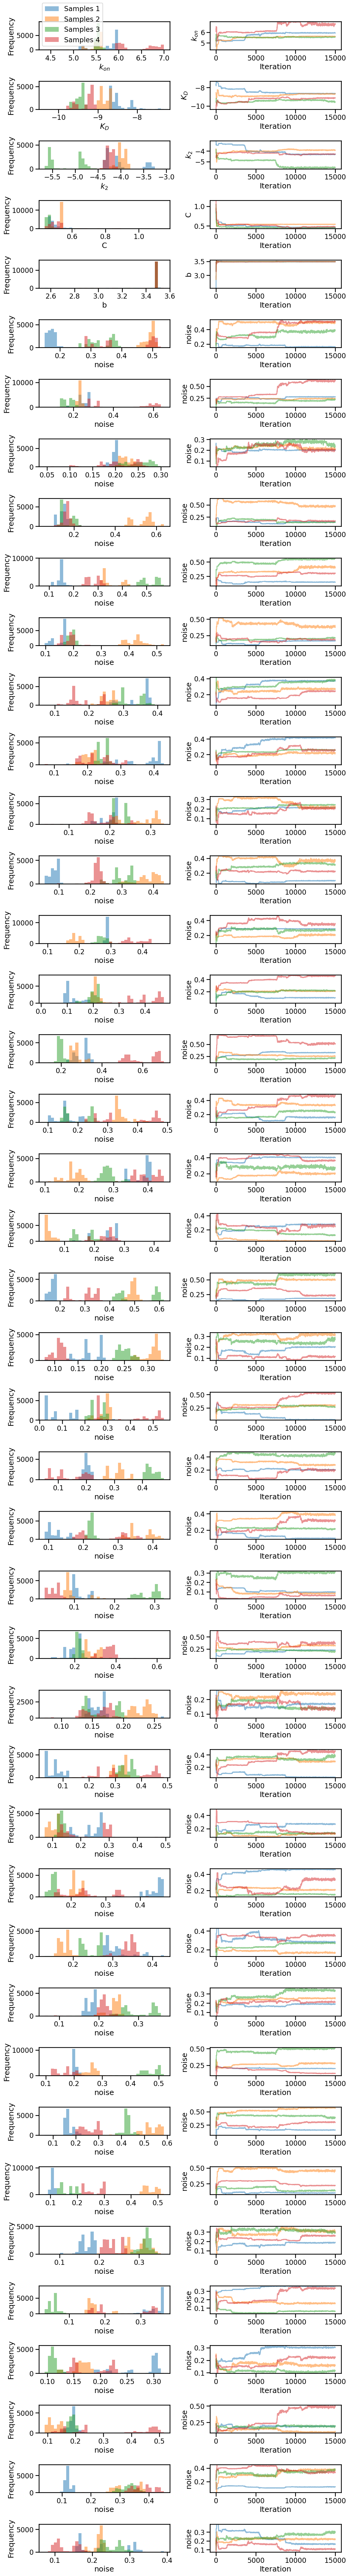

In [145]:
import pints.plot

parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'b'] + ['noise' for val in range(2*len(rtots))]
pints.plot.trace(chains, parameter_names=parameter_names)
plt.show()

In [146]:
chain = chains[0]
chain = chain[10000:]
chains1 = chains[:, 10000 :]
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'b'] + ['noise' for val in range(2*len(rtots))]
#pints.plot.pairwise(chain, kde=True,  parameter_names=parameter_names)
#plt.show()

In [ ]:

fig, axes = pints.plot.series(chains1[0], problem)

#fig.set_size_inches(12,4.5)
#plt.plot(A0s1, values, c='orange', label='data')
plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()

"\nfig, axes = pints.plot.series(chains1[0], problem)\n\n#fig.set_size_inches(12,4.5)\n#plt.plot(A0s1, values, c='orange', label='data')\nplt.legend()\nplt.xscale('log')\nplt.xlabel(r'Antibody Concentration')\nplt.show()\n"

In [ ]:

results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=parameter_names)
print(results)
results_list = results._summary_list
results_dic = {}
means =[]
stds = []
l_perc = []
h_perc = []
rhats = []
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'b']
for i, param in enumerate(parameter_names):
    holder = results_list[i]
    means.append(holder[1])
    stds.append(holder[2])
    l_perc.append(holder[3])
    h_perc.append(holder[7])
    rhats.append(holder[8])

results_dic['parameter'] = parameter_names
results_dic['mean'] = means
results_dic['std'] = stds
results_dic['2.5%'] = l_perc
results_dic['97.5%'] = h_perc
results_dic['rhat'] = rhats


"\nresults = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=parameter_names)\nprint(results)\nresults_list = results._summary_list\nresults_dic = {}\nmeans =[]\nstds = []\nl_perc = []\nh_perc = []\nrhats = []\nparameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'b']\nfor i, param in enumerate(parameter_names):\n    holder = results_list[i]\n    means.append(holder[1])\n    stds.append(holder[2])\n    l_perc.append(holder[3])\n    h_perc.append(holder[7])\n    rhats.append(holder[8])\n\nresults_dic['parameter'] = parameter_names\nresults_dic['mean'] = means\nresults_dic['std'] = stds\nresults_dic['2.5%'] = l_perc\nresults_dic['97.5%'] = h_perc\nresults_dic['rhat'] = rhats\n"

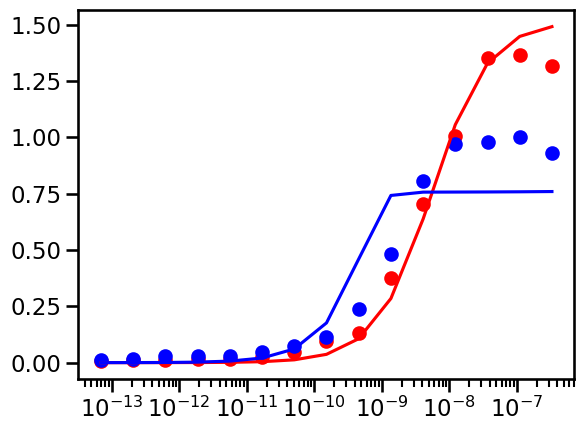

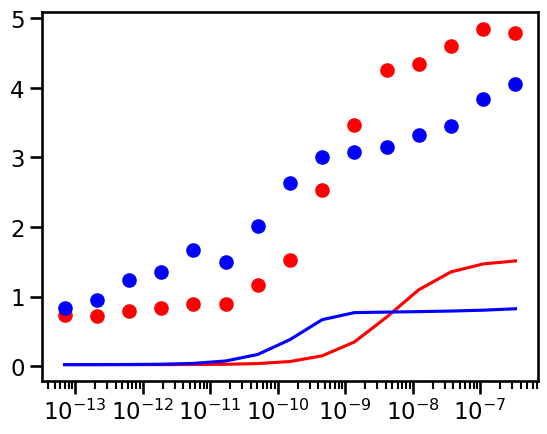

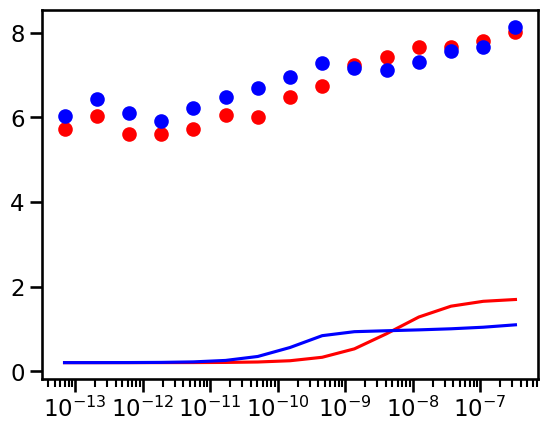

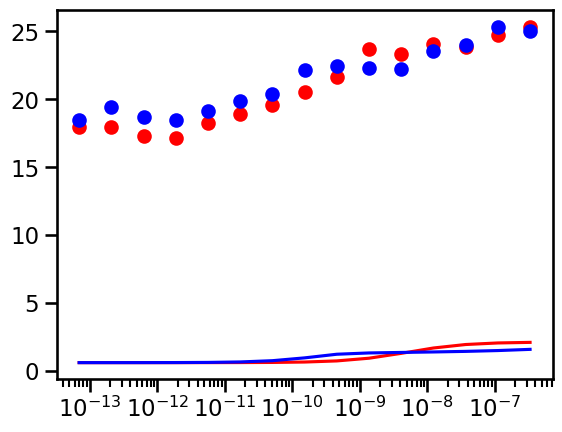

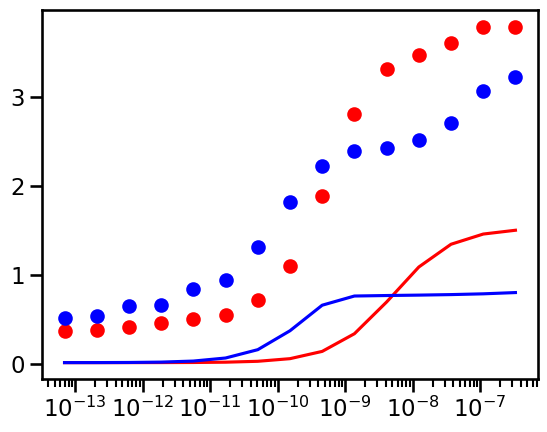

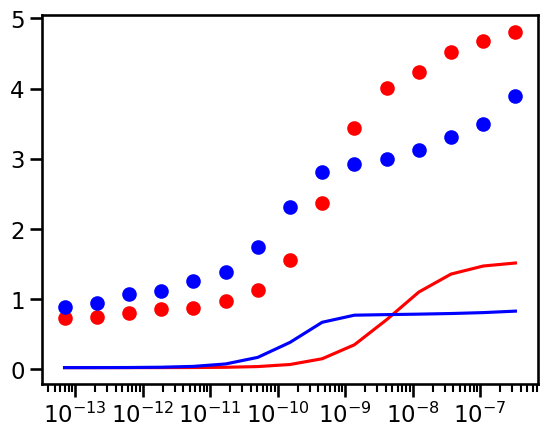

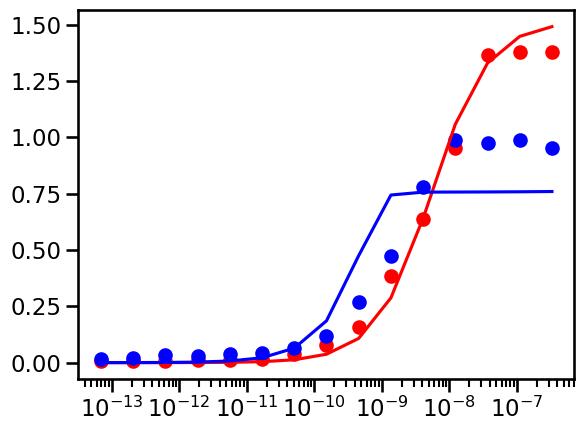

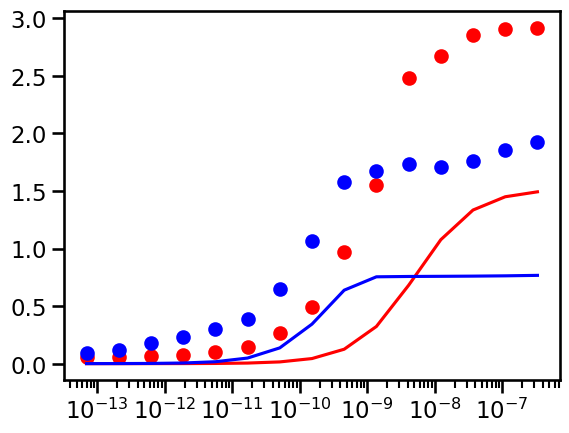

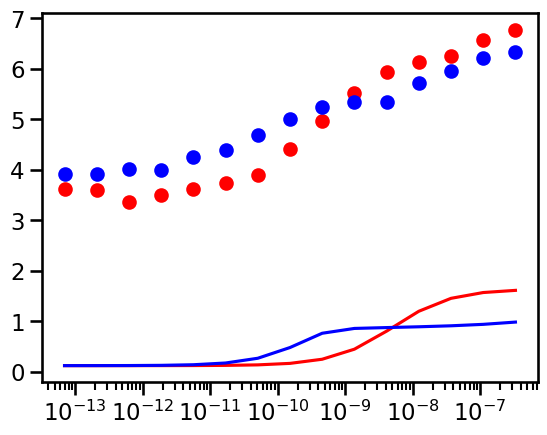

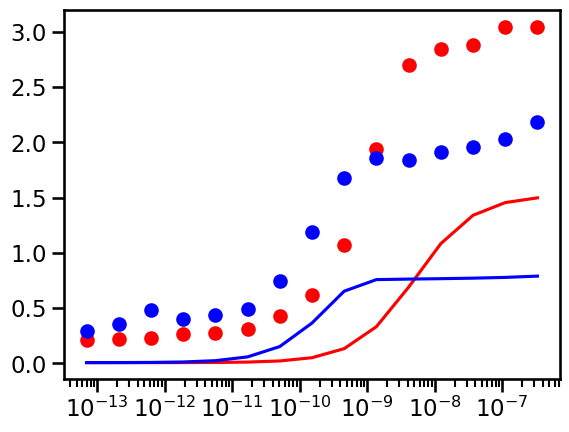

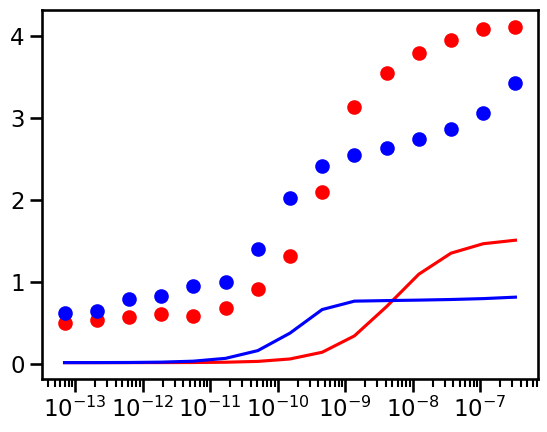

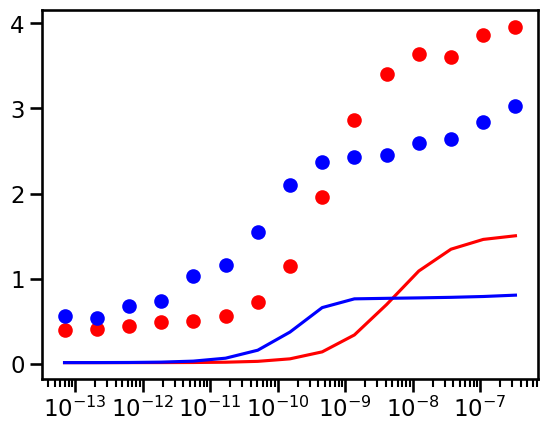

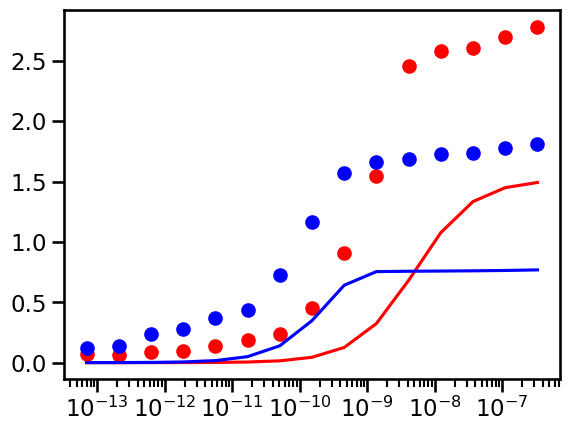

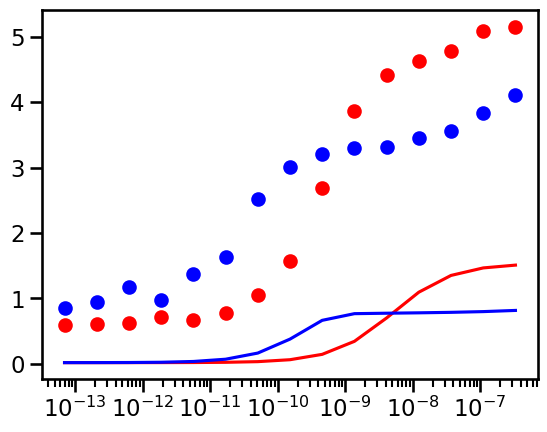

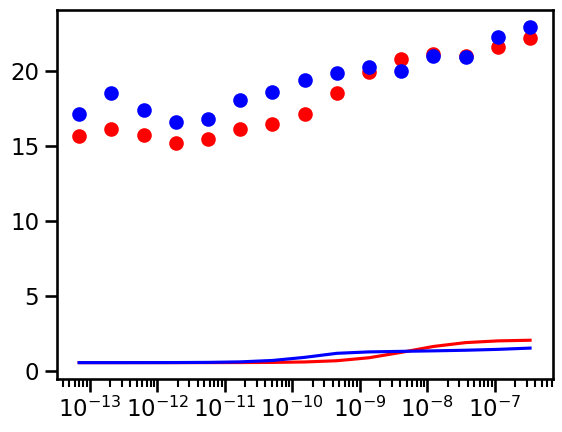

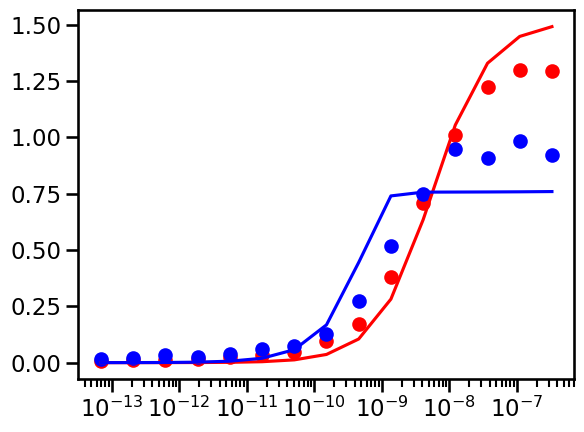

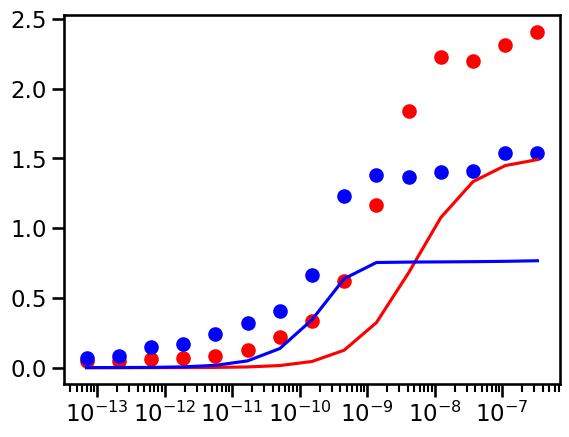

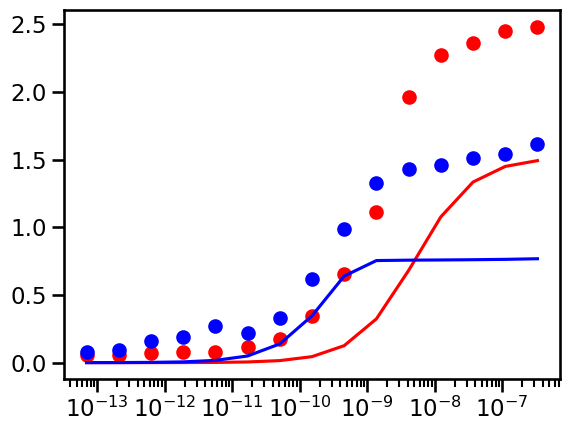

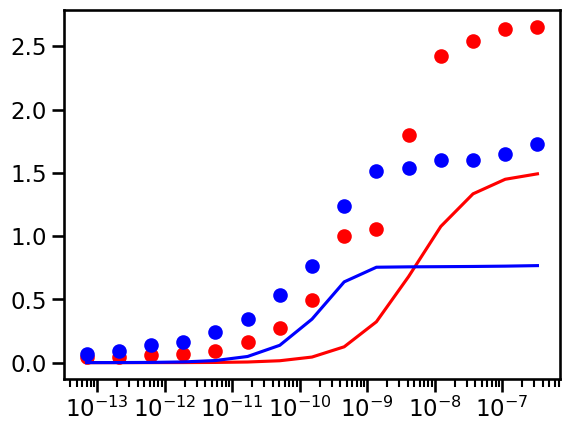

In [ ]:
parameters = [5.47, -8, -2, 0.18, 2]
sim = simulate_model(conc, parameters=results_dic['parameter'])
for i in range(len(rtots)):
    fig = plt.figure()
    plt.semilogx(conc, sim[:, 2*i], label='monovalent fit', c='red')
    plt.semilogx(conc, sim[:, 2*i+1], label = 'bivalent fit', c='blue')
    plt.scatter(conc, monos[i], label='monovalent data', c='red')
    plt.scatter(conc, bivs[i], label='bivalent data', c='blue')
    plt.xscale('log')
    plt.show()